# Running a continuous time Markov Model simulation of antibody binding dynamics on an antigen pattern

This notebook demonstrates the basic capability of a fully calibrated Continuous Time Markov Chain (CTMC) model to simulate binding dynamics on an arbitrary pattern. As a user, you may define an antigen pattern by supplying a set of coordinates to generate a transition matrix (for quick results, patterns should be kept to fewer than 8 antigens or kept sparsely connected if more). Then supply an in input SPR program to simulate, specifying timepoints of injections with corresponding solution-phase antibody concentration values. The simulation will output stratified plots of the pattern dynamics from an initial condition of an empty structure. 


### getting help
For help regarding a particular function in the spatial tolerance library, use the help() function for more information.

In [1]:
import os, sys
currentdir = os.getcwd()
parentdir = os.path.abspath(os.path.join(currentdir, os.pardir))
sys.path.append(parentdir)
from spatial_tolerance_lib import antibody_functions_lib as mk

####### HELP EXAMPLE ##########
help(mk.generate_state_from_id)

Help on function generate_state_from_id in module spatial_tolerance_lib.antibody_functions_lib:

generate_state_from_id(input_state_id)
    given an input state ID, output the corresponding site status information
    
    Parameters
    -------------
    input_state_id 
     the state ID for a given arrangement of antibodies for a particular pattern system



## Generate the transition matrix for a pattern
In the example below, we input the coordinates for a simple quadrilateral structure and a right triangle. Transition matrices are then generated for both and saved to files with the corresponding input names.

In [ ]:
import os, sys
currentdir = os.getcwd()
parentdir = os.path.abspath(os.path.join(currentdir, os.pardir))
sys.path.append(parentdir)
from spatial_tolerance_lib import antibody_functions_lib as mk
import numpy as np

name_list = ['example_quadrilateral_pattern', 'right triangle'] # MODIFY THIS LINE!
coordinates_list = [np.array([[0,0],[15,5],[13,17],[5,20]]) , np.array([[0,0],[20,0],[0,13]])] # MODIFY THIS LINE!

run_list = [0, 1]
for run in run_list:
    transition_matrix_name = name_list[run]
    dir = mk.create_directory(transition_matrix_name)
    coordinate_vector = np.array(coordinates_list[run])
    site_status_vector, distance_matrix, neighbor_matrix, neighbor_directory = mk.configure_space(cutoff_dist = 28, coord_v=coordinate_vector, transition_m_name=transition_matrix_name)
    mk.transition_m_continuous(coordinate_vector, site_status_vector, neighbor_directory, distance_matrix, transition_matrix_name)

## Simulating antibody dynamics
Now that we have generated a transition matrix, we will simulate dynamics on the pattern. Start by importing the required modules.

In [3]:
import os, sys
currentdir = os.getcwd()
parentdir = os.path.abspath(os.path.join(currentdir, os.pardir))
sys.path.append(parentdir)
from spatial_tolerance_lib import complete_ctmc_v1 as ctmc
import numpy as np
import imp
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rcParams.update({'font.size': 25})

## parameters 
Next we define the properties of our run. In the time points input, we specify at which time (in seconds) an injection of particular concentration will occur. The concentrations are specified in the concentrations input vector. We then supply the kinetic data in the form of the monovalent rates $k_1$ and $k_{-1}$ as well as the bivalent conversion rates in the form of a parameterized KD2 equation. Also include the name of the output directory.

In [7]:
### PARAMETERS ###
time_points = np.array([0,1000,1200])                           # MODIFY THIS LINE!
final_time = 2000                                                # MODIFY THIS LINE!
concentrations = np.array([0.06,1.2,0.1]) # nM                     # MODIFY THIS LINE!
master_name = "demo"                                              # MODIFY THIS LINE!
transition_matrix = "example_quadrilateral_pattern"               # MODIFY THIS LINE!

mono_rates = np.array([0.02132598786, 0.0005306938055585968]) #nM-1 s-1  and s-1
KD_fx = [25.4726412,  0.27,       1.1,        0.33,       0.99]

## run the sim
Run the cell below to simulate the SPR run. This will generate stratified plots and the probability distribution of states as it evolves over time during the run.

[0.06 0.06 0.06 ... 0.1  0.1  0.1 ]
0.19


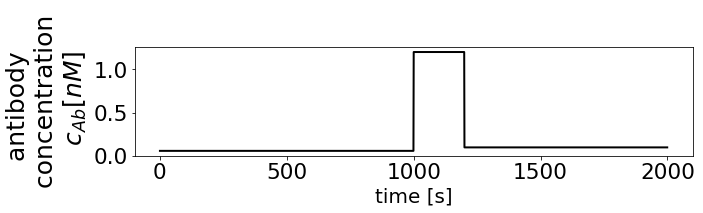

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.94903221e-01 3.20623119e-04 1.60261473e-04 ... 2.89591964e-10
  7.04123048e-10 8.67593102e-14]
 [9.89832576e-01 3.90996911e-04 2.10651917e-04 ... 1.95171327e-09
  3.98857021e-09 5.88750896e-13]
 ...
 [3.40070731e-05 1.47335451e-04 1.47332632e-04 ... 3.50142496e-02
  1.38460014e-01 2.86712912e-02]
 [3.40296749e-05 1.47408034e-04 1.47405220e-04 ... 3.50028971e-02
  1.38415130e-01 2.86456892e-02]
 [3.40522380e-05 1.47480500e-04 1.47477691e-04 ... 3.49915599e-02
  1.38370307e-01 2.86201300e-02]]


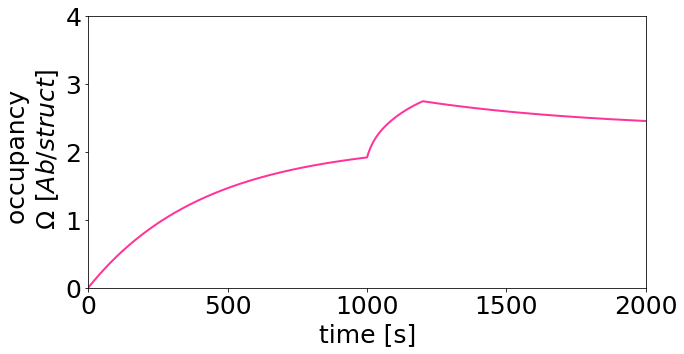

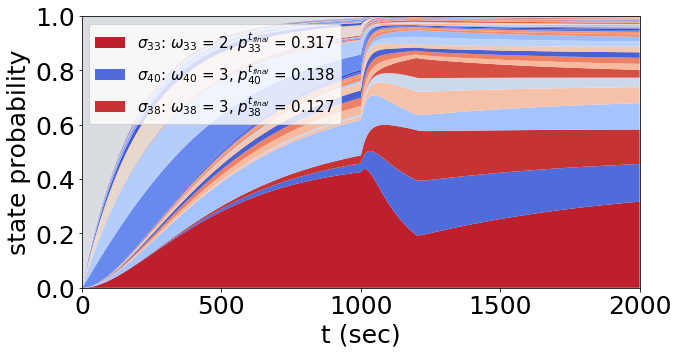

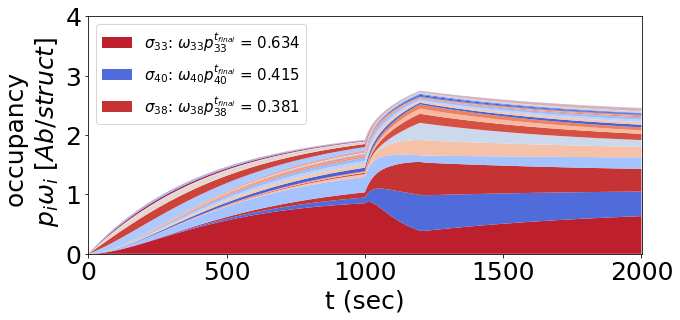

0

In [8]:
output_directory = master_name+"/"+transition_matrix
if not os.path.exists(output_directory):
            os.makedirs(output_directory)
time_points
weighted_concs = np.zeros((final_time))
timepoints_new = list(time_points) + [final_time]
for i in range(0, len(time_points)):
    for j in range(timepoints_new[i],timepoints_new[i+1]):
        weighted_concs[j] = concentrations[i]
print(weighted_concs)   
fixed_conc = np.average(weighted_concs)
print(fixed_conc)
plt.figure(figsize=(10, 2))
plt.plot(weighted_concs,c="k", linewidth=2)
plt.ylabel("antibody \n concentration \n $c_{Ab} [nM]$",fontsize=25)
plt.xlabel("time [s]",fontsize=20)
plt.savefig(output_directory+"/concentration_injections.svg")
plt.show()
plt.close()

denovo_sim_0 = ctmc.Simulation(transition_matrix_name = transition_matrix,
                             mono_rates = mono_rates, 
                             KD_fx = KD_fx,
                             concentrations = concentrations, 
                             time_points = time_points, 
                             final_time = final_time) 
denovo_sim_0.print_graph=True
denovo_sim_0.SPR_run()


# Monte Carlo version
For larger patterns, it is more economic to simulate antibody binding dynamics with the sampling-based Monte Carlo or random-walk style approach. This is in contrast to generating a complete transition matrix for the system. Instead, states are examined locally for possible transitions, and the system is allowed to "wander" randomly. By repeating this process many times, we can get a noisy approximation of the state probability distributions at each time point.

In [1]:
import os, sys
currentdir = os.getcwd()
parentdir = os.path.abspath(os.path.join(currentdir, os.pardir))
sys.path.append(parentdir)
from spatial_tolerance_lib import mcm_lib_pbc as mc
import matplotlib.pyplot as plt
import scipy.optimize as opt
import ipdb
import numpy as np
import imp
import matplotlib.cm as cm
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rcParams.update({'font.size': 25})

## Supply pattern coordinates
As with the enumerative transition-matrix approach, we will again supply coordinates to define an antigen pattern. This time, instead of simulating just 3 or 4 antigens, we will define a more complex pattern with 7 highly connected antigens, but we will also include the quadrilateral from the above example to compare the sampling approach results with the deterministic approach above. 

In [2]:
reload(mc)
name_list = ['example_septamer',                                 # MODIFY THIS LINE!
             'example_quadrilateral_pattern']
coordinates_list = [
    [[0,0],[15,5],[13,17],[5,20],[20,0],[0,13],[20,10]],         # MODIFY THIS LINE!
    [[0,0],[15,5],[13,17],[5,20]]
    ]
times = np.array([0,1000,1200,2000])                             # MODIFY THIS LINE!
concentrations = np.array([0.06e-9,1.2e-9,0.1e-9]) # M           # MODIFY THIS LINE!

('example_quadrilateral_pattern', [[0, 0], [15, 5], [13, 17], [5, 20]])


  0%|          | 0/3 [00:00<?, ?it/s]

example_quadrilateral_pattern


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


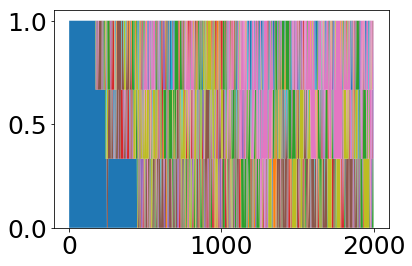

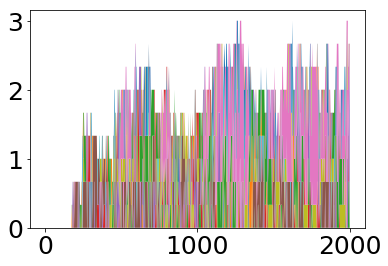

In [3]:
imp.reload(mc)
experiment = 1
print(name_list[experiment],coordinates_list[experiment])
box_size = np.max(coordinates_list[experiment])+31
origami = mc.Pattern(name = name_list[experiment],coordinates = np.array(coordinates_list[experiment]))
distance_matrix = origami.configure_ab_ag_system_pbc(cutoff_distance = 28, box_size=box_size)
origami.output_site_configuration()
dir = mc.get_save_directory(name = origami.name)

origami.program_kinetics(times, concentrations)
origami.initialize_antibody_environment([0.02132598797*10**9,0.0005306938,2.66927399416,0.19781887754],dir)
repeats = 3
origami.multirun(repeats)
mc.stratified_spr_plots(name_list[experiment], times[-1])

('example_septamer', [[0, 0], [15, 5], [13, 17], [5, 20], [20, 0], [0, 13], [20, 10]])


  0%|          | 0/200 [00:00<?, ?it/s]

example_septamer


100%|██████████| 200/200 [16:10<00:00,  4.85s/it]


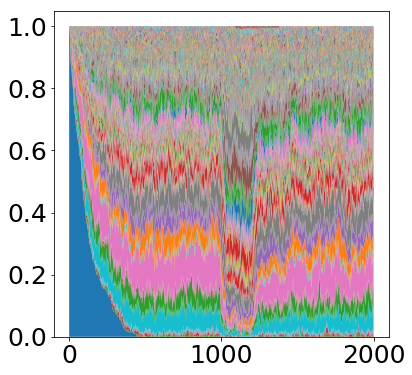

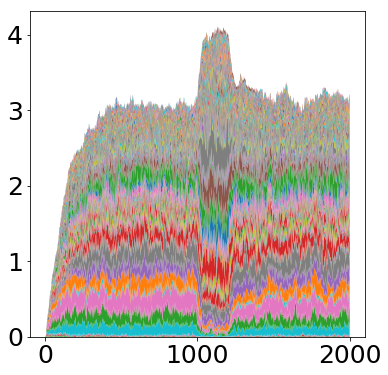

In [13]:
imp.reload(mc)
experiment = 0
print(name_list[experiment],coordinates_list[experiment])
box_size = np.max(coordinates_list[experiment])+31
origami = mc.Pattern(name = name_list[experiment],coordinates = np.array(coordinates_list[experiment]))
distance_matrix = origami.configure_ab_ag_system_pbc(cutoff_distance = 28, box_size=box_size)
origami.output_site_configuration()
dir = mc.get_save_directory(name = origami.name)

origami.program_kinetics(times, concentrations)
origami.initialize_antibody_environment([0.02132598797*10**9,0.0005306938,2.66927399416,0.19781887754],dir)
repeats = 200
origami.multirun(repeats)
mc.stratified_spr_plots(name_list[experiment], times[-1])